In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats



from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, auc

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../data')

import functions
import plot
import clean


%load_ext autoreload
%autoreload 2

sns.set()



In [3]:
columns = ['DEP', 'PT', 'AGE', 'GT', 'EL', 'SC', 'CO', 'FA', 'ST']

## Data Import & Cleaning

Psychological Operations Assessment and Selection (POAS)

In [4]:
poas_filepath = '../data/poas'
poas_filenames = ['poas16.xlsx', 'poas17.xlsx', 'poas18.xlsx', 'poas19.xlsx', 'poas20.xlsx', 'poas21.xlsx', 'poas22.xlsx']


poas = clean.clean_data(poas_filepath, poas_filenames, columns, 'POAS')
poas.to_excel('../data/poas/poas.xlsx', index=False)
poas

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


,RANK,RACE,MOS,SEC,AB,RGR,PT,ED,MARITAL,DEP,...,GT,EL,SC,CO,FA,ST,WVR,RESULT,CODE,GROUP
0,SGT,O,42A,1,0,0,276,HSD,M,1,...,110,107,106,105,106,106,1,IVW,IVW,POAS
1,SSG,O,11B,1,0,0,242,HSD,M,1,...,111,116,119,118,119,116,0,IVW,IVW,POAS
2,SPC,H,42A,1,0,0,245,4YR,M,4,...,115,111,113,110,112,112,0,FAILED ARMY STANDARD 60/180 (HB),APFT,POAS
3,SGT,W,11B,1,0,0,295,HSD,M,1,...,108,116,116,119,120,117,0,SELECT,SEL,POAS
4,SPC,H,11C,0,1,0,282,4YR,M,1,...,124,121,120,122,122,123,0,IVW,IVW,POAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2645,PFC,B,92Y,0,0,0,298,4 YR,M,2,...,124,119,121,116,117,117,0,INVOLUNTARY WITHDRAWAL,IVW,POAS
2646,PFC,W,12B,1,0,0,228,HSD,M,1,...,103,108,105,109,109,105,0,PFA FAILURE,PFA,POAS
2647,SPC,W,25N,1,0,0,277,HSD,S,0,...,104,105,106,105,104,106,0,NON-SELECT,BRD,POAS
2648,PFC,W,14T,1,0,0,229,HSD,M,0,...,102,100,100,98,97,100,0,NON-SELECT,BRD,POAS


Special Forces Assesment and Selection (SFAS)

In [5]:
sfas_filepath = '../data/sfas'
sfas_filenames = ['sfas16.xlsx', 'sfas17.xlsx', 'sfas18.xlsx', 'sfas19.xlsx', 'sfas20.xlsx', 'sfas21.xlsx', 'sfas22.xlsx']

sfas = clean.clean_data(sfas_filepath, sfas_filenames, columns, 'SFAS')
poas.to_excel('../data/sfas/sfas.xlsx', index=False)
sfas

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


,RANK,RACE,MOS,SEC,AB,RGR,PT,ED,MARITAL,DEP,...,GT,EL,SC,CO,FA,ST,WVR,RESULT,CODE,GROUP
0,SGT,B,11B,1,0,0,274,HSD,M,2,...,113,101,103,98,99,103,0,INVOLUNTARY WITHDRAW,IVW,SFAS
1,SPC,W,12K,0,0,0,275,GED,M,0,...,114,123,122,124,125,121,1,INVOLUNTARY WITHDRAW,IVW,SFAS
2,SGT,W,11B,1,1,0,290,HSD,M,2,...,110,119,114,112,113,119,0,SELECTED,SEL,SFAS
3,SGT,W,13B,1,0,1,297,HSD,M,1,...,115,112,112,111,112,113,0,SELECTED,SEL,SFAS
4,SPC,H,91B,1,1,0,247,GED,M,4,...,117,111,112,109,109,114,0,INVOLUNTARY WITHDRAW,IVW,SFAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,SGT,W,11B,1,0,0,292,HSD,S,0,...,101,108,110,111,111,109,0,INVOLUNTARY WITHDRAW,IVW,SFAS
8326,SSG,W,13F,1,1,1,300,6 YR,S,0,...,120,123,123,123,123,123,0,SELECTED,SEL,SFAS
8327,SGT,W,15T,1,0,0,294,HSD,M,0,...,129,130,131,128,128,130,0,SELECTED,SEL,SFAS
8331,SGT,W,92F,1,1,0,274,4 YR,D,0,...,135,141,140,142,143,140,0,PFA FAILURE,PFA,SFAS


## Initial Overview

View of overall data

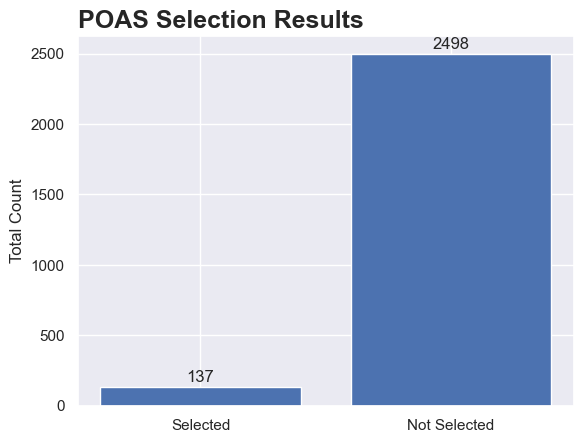

In [25]:
poas_selected = functions.equal_column_val(poas, 'RESULT', 'SELECTED')
poas_not_selected = functions.not_column_val(poas, 'RESULT', 'SELECTED')

outcome = [poas_selected.RESULT.count(), poas_not_selected.RESULT.count()]


plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'POAS Selection Results', 'Total Count')




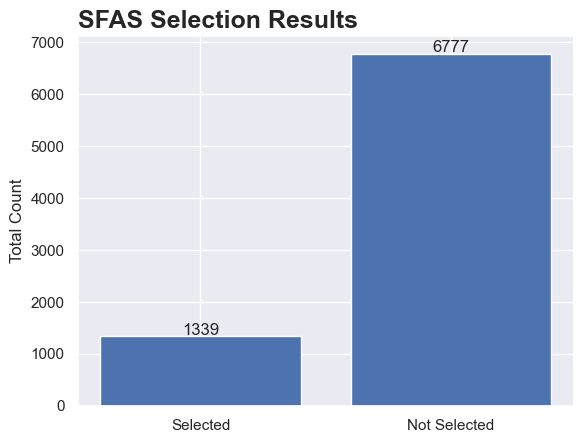

In [7]:
sfas_selected = functions.equal_column_val(sfas, 'RESULT', 'SELECTED')
sfas_not_selected = functions.not_column_val(sfas, 'RESULT', 'SELECTED')

outcome = [sfas_selected.RESULT.count(), sfas_not_selected.RESULT.count()]


plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'SFAS Selection Results', 'Total Count')

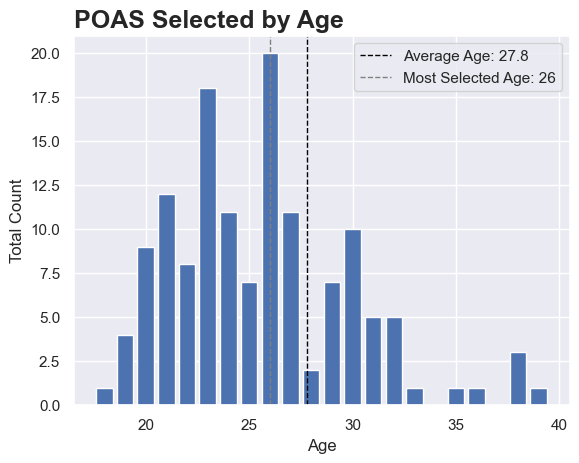

In [8]:
poas_ages = poas_selected.groupby('AGE').size().reset_index(name='counts')
poas_avg_age = poas_ages.mean()
poas_most_age = poas_ages.loc[poas_ages['counts'].idxmax(), 'AGE']

plot.age_bar_plot(poas_ages['AGE'], poas_ages['counts'], 'POAS Selected by Age', 'Age', 'Total Count', poas_avg_age[0], poas_most_age)


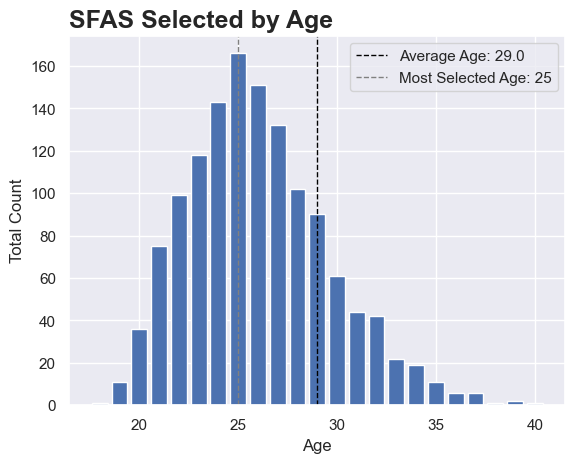

In [9]:
sfas_ages = sfas_selected.groupby('AGE').size().reset_index(name='counts')
sfas_avg_age = sfas_ages.mean()
sfas_most_age = sfas_ages.loc[sfas_ages['counts'].idxmax(), 'AGE']

plot.age_bar_plot(sfas_ages['AGE'], sfas_ages['counts'], 'SFAS Selected by Age', 'Age', 'Total Count', sfas_avg_age[0], sfas_most_age)

## Key Features

Numerical look at features that are often considered "important"

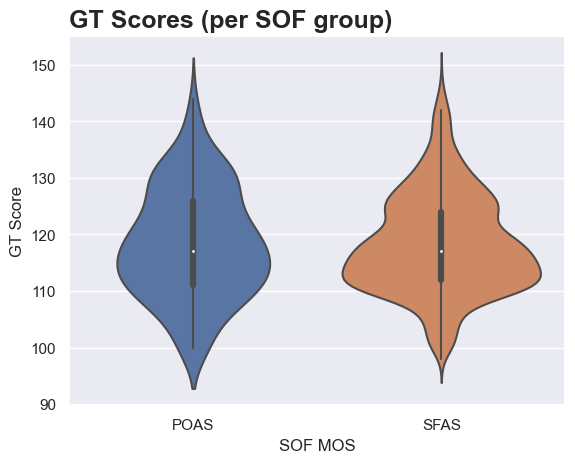

In [20]:
both = [poas, sfas]
combined = pd.concat(both, axis=0, ignore_index=True)

cs = functions.equal_column_val(combined, 'RESULT', 'SELECTED')

plot.violin_plot('GROUP', 'GT', cs, 'GT Scores (per SOF group)', 'SOF MOS', 'GT Score')



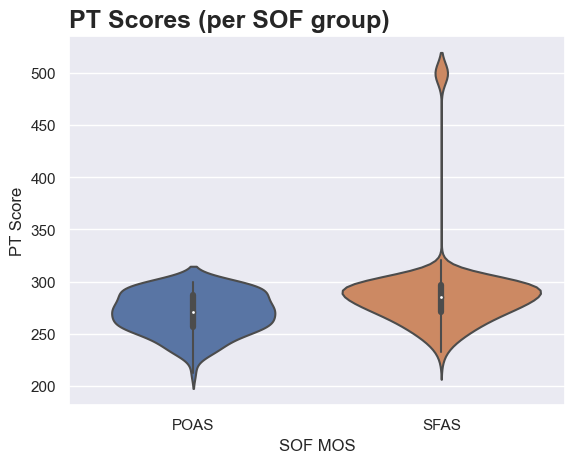

In [21]:
plot.violin_plot('GROUP', 'PT', cs, 'PT Scores (per SOF group)', 'SOF MOS', 'PT Score')

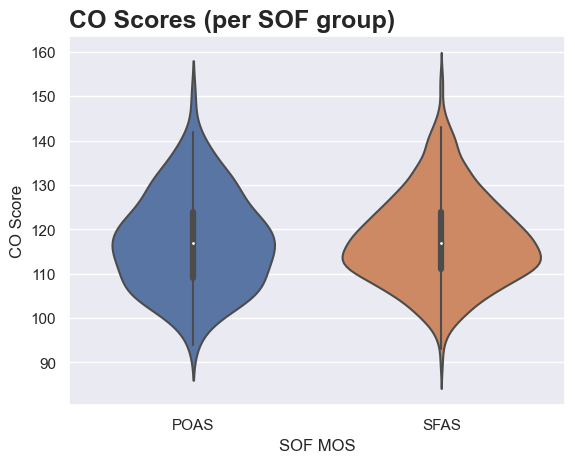

In [22]:
plot.violin_plot('GROUP', 'CO', cs, 'CO Scores (per SOF group)', 'SOF MOS', 'CO Score')

<BarContainer object of 13 artists>

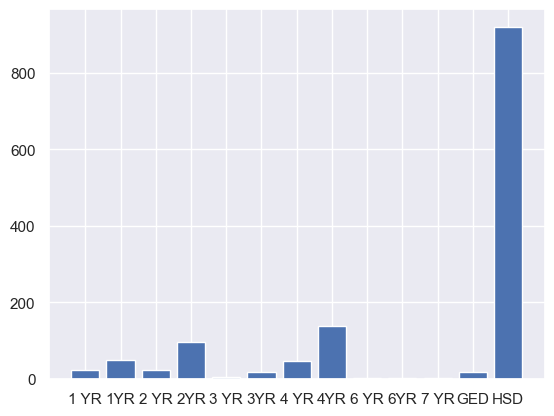

In [28]:
sfas_ed = sfas_selected.groupby('ED').size().reset_index(name='counts')

fig, ax = plt.subplots()
ax.bar( sfas_ed['ED'], sfas_ed['counts'])

# plot.age_bar_plot(sfas_ed['ED'], sfas_ages['counts'], 'SFAS Selected by Age', 'Age', 'Total Count', sfas_avg_age[0], sfas_most_age)